In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
train_batch = 128
test_batch = 16
EPOCH = 200
learning_rate = 0.0001

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train = False,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch,
                                          shuffle = True, num_workers = 1)

testloader = torch.utils.data.DataLoader(testset, batch_size = test_batch,
                                          shuffle = True, num_workers = 1)

0it [00:00, ?it/s]

100%|█████████▉| 169746432/170498071 [00:11<00:00, 17632005.09it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


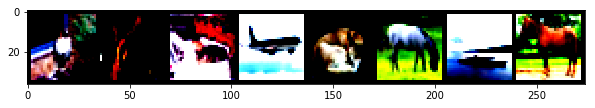

In [4]:
example = iter(trainloader).next()
ex_image, _ = example

ex_im = ex_image[:8]
ex_im = torchvision.utils.make_grid(ex_im)
ex_im = ex_im.permute(1,2,0)

plt.figure(figsize = (10,10))
plt.imshow(ex_im)

In [5]:
# model load

from torchvision import models
vgg = models.vgg16(pretrained=True)
vgg

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/.cache/torch/checkpoints/vgg16-397923af.pth

  0%|          | 0.00/528M [00:00<?, ?B/s]
  2%|▏         | 11.3M/528M [00:00<00:04, 118MB/s]
  4%|▍         | 21.9M/528M [00:00<00:04, 116MB/s]
  6%|▌         | 32.7M/528M [00:00<00:04, 115MB/s]
  8%|▊         | 43.8M/528M [00:00<00:04, 115MB/s]
 10%|█         | 54.4M/528M [00:00<00:04, 114MB/s]
 12%|█▏        | 65.3M/528M [00:00<00:04, 114MB/s]
 14%|█▍        | 76.4M/528M [00:00<00:04, 115MB/s]
 17%|█▋        | 87.4M/528M [00:00<00:04, 115MB/s]
 19%|█▊        | 98.5M/528M [00:00<00:03, 115MB/s]
 21%|██        | 110M/528M [00:01<00:03, 116MB/s] 
 23%|██▎       | 120M/528M [00:01<00:03, 115MB/s]
 25%|██▍       | 131M/528M [00:01<00:03, 112MB/s]
 27%|██▋       | 142M/528M [00:01<00:03, 113MB/s]
 29%|██▉       | 153M/528M [00:01<00:03, 113MB/s]
 31%|███       | 164M/528M [00:01<00:03, 114MB/s]
 33%|███▎      | 175M/528M [00:01<00:03, 108MB/s]
 35%|███▌      | 186M/52

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
# 모델 고정하기(학습x)
for p in vgg.features.parameters():
    p.requires_grad = False

In [7]:
# 출력층 수정하기
vgg.classifier[6].out_features = 10

In [8]:
optimizer = optim.SGD(vgg.classifier.parameters(), lr = learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
vgg.to(device)
print(device)

cuda


170500096it [00:30, 17632005.09it/s]                               

In [9]:
vgg.train()
import time

for e in range(1, EPOCH+1):
    start_time = time.time()
    running_loss = 0
    for i, data in enumerate(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        
        now = time.time()
        print('\r EPOCH : [%d/%d], ITER : [%d/%d] LOSS : %.7f, Time : %d' 
              %(e, EPOCH, i, len(trainloader), running_loss, now - start_time), end = '')
        
    print('\n')

 EPOCH : [1/200], ITER : [390/391] LOSS : 1772.5776367, Time : 16

 EPOCH : [2/200], ITER : [390/391] LOSS : 618.9889526, Time : 16

 EPOCH : [3/200], ITER : [390/391] LOSS : 552.3051758, Time : 16

 EPOCH : [4/200], ITER : [390/391] LOSS : 525.6095581, Time : 17

 EPOCH : [5/200], ITER : [390/391] LOSS : 504.1810608, Time : 16

 EPOCH : [6/200], ITER : [390/391] LOSS : 489.2970581, Time : 16

 EPOCH : [7/200], ITER : [390/391] LOSS : 478.4012451, Time : 16

 EPOCH : [8/200], ITER : [390/391] LOSS : 470.9440918, Time : 16

 EPOCH : [9/200], ITER : [390/391] LOSS : 462.0360718, Time : 16

 EPOCH : [10/200], ITER : [390/391] LOSS : 455.3473511, Time : 16

 EPOCH : [11/200], ITER : [390/391] LOSS : 449.8039856, Time : 16

 EPOCH : [12/200], ITER : [390/391] LOSS : 445.0276794, Time : 16

 EPOCH : [13/200], ITER : [390/391] LOSS : 440.0677490, Time : 16

 EPOCH : [14/200], ITER : [390/391] LOSS : 436.0615234, Time : 16

 EPOCH : [15/200], ITER : [390/391] LOSS : 432.1404114, Time : 16

 EP

 EPOCH : [123/200], ITER : [390/391] LOSS : 300.9846191, Time : 16

 EPOCH : [124/200], ITER : [390/391] LOSS : 298.7431641, Time : 16

 EPOCH : [125/200], ITER : [390/391] LOSS : 300.1672668, Time : 16

 EPOCH : [126/200], ITER : [390/391] LOSS : 299.1223450, Time : 16

 EPOCH : [127/200], ITER : [390/391] LOSS : 300.3968201, Time : 16

 EPOCH : [128/200], ITER : [390/391] LOSS : 298.1256714, Time : 16

 EPOCH : [129/200], ITER : [390/391] LOSS : 296.7566833, Time : 16

 EPOCH : [130/200], ITER : [390/391] LOSS : 295.8278503, Time : 16

 EPOCH : [131/200], ITER : [390/391] LOSS : 294.1919556, Time : 16

 EPOCH : [132/200], ITER : [390/391] LOSS : 294.2678528, Time : 16

 EPOCH : [133/200], ITER : [390/391] LOSS : 293.6296692, Time : 16

 EPOCH : [134/200], ITER : [390/391] LOSS : 293.4170837, Time : 16

 EPOCH : [135/200], ITER : [390/391] LOSS : 291.4653015, Time : 16

 EPOCH : [136/200], ITER : [390/391] LOSS : 291.6846619, Time : 16

 EPOCH : [137/200], ITER : [390/391] LOSS : 291.

In [40]:
vgg.eval()
correct = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        val_images, val_labels = data
        
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = vgg(val_images)
        pred = val_outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(val_labels.view_as(pred)).sum().item()
        
print('Accuracy of the network on 10000 test images : %.3f %%' %(100 * correct / len(testloader.dataset)))               

torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 3

torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 3